<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-Foray-Into-Discrete/Fast-Fourier-Transformation" data-toc-modified-id="First-Foray-Into-Discrete/Fast-Fourier-Transformation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First Foray Into Discrete/Fast Fourier Transformation</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Fourier-Transformation" data-toc-modified-id="Fourier-Transformation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fourier Transformation</a></span></li><li><span><a href="#DFT-In-Action" data-toc-modified-id="DFT-In-Action-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>DFT In Action</a></span></li><li><span><a href="#Fast-Fourier-Transformation-(FFT)" data-toc-modified-id="Fast-Fourier-Transformation-(FFT)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Fast Fourier Transformation (FFT)</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2018-12-13 16:10:17 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2


# First Foray Into Discrete/Fast Fourier Transformation

In many real-world applications, signals are typically represented as a sequence of numbers that are time dependent. For example, digital audio signal would be one common example, or the hourly temperature in California would be another one. In order to extract meaningful characteristics from these kind of data, many different transformation techniques have been developed to decompose it into simpler individual pieces that are much easier and compact to reason with.

**Discrete Fourier Transformation (DFT)** is one of these algorithms that takes a signal as an input and breaks it down into many individual frequency components. Giving us, the end-user, easier pieces to work with. For the digital audio signal, applying DFT gives us what tones are represented in the sound and at what energies.

Some basics of digital signal processing is assumed. The following link contains an excellent primer to get people up to speed. I feverishly recommend going through all of it if the reader is not pressed with time. [Blog: Seeing Circles, Sines, And Signals a Compact Primer On Digital Signal Processing](https://jackschaedler.github.io/circles-sines-signals/index.html)

## Correlation

Correlation is a widely used concept in signal processing. It must be noted that the definition of correlation here is slightly different from the definition we encounter in statistics. In the context of signal processing, correlation measures how similar two signals are by computing the dot product between the two. i.e. given two signals $x$ and $y$, the correlation of the two signal can be computed using:

\begin{align}
\sum_{n=0}^N x_n \cdot y_n
\end{align}

The intuition behind this is that if the two signals are indeed similar, then whenever $x_n$ is positive/negative then $y_n$ should also be positive/negative. Hence when two signals' sign often matches, the resulting correlation number will also be large, indicating that the two signals are similar to one another. It is worth noting that correlation can also take on negative values, a large negative correlation means that the signal is also similar to each other, but one is inverted with respect to the other.

In [3]:
# create examples of two signals that are dissimilar
# and two that are similar to illustrate the concept


def create_signal(sample_duration, sample_freq, signal_type, signal_freq):
    """
    Create some signals to work with, e.g. if we were to sample at 100 Hz
    (100 times per second) and collect the data for 10 seconds, resulting
    in 1000 samples in total. Then we would specify sample_duration = 10,
    sample_freq = 100.
    
    Apart from that, we will also give the option of generating sine or cosine
    wave and the frequencies of these signals
    """
    raw_value = 2 * np.pi * signal_freq * np.arange(0, sample_duration, 1. / sample_freq)
    if signal_type == 'cos':
        return np.cos(raw_value)
    elif signal_type == 'sin':
        return np.sin(raw_value)

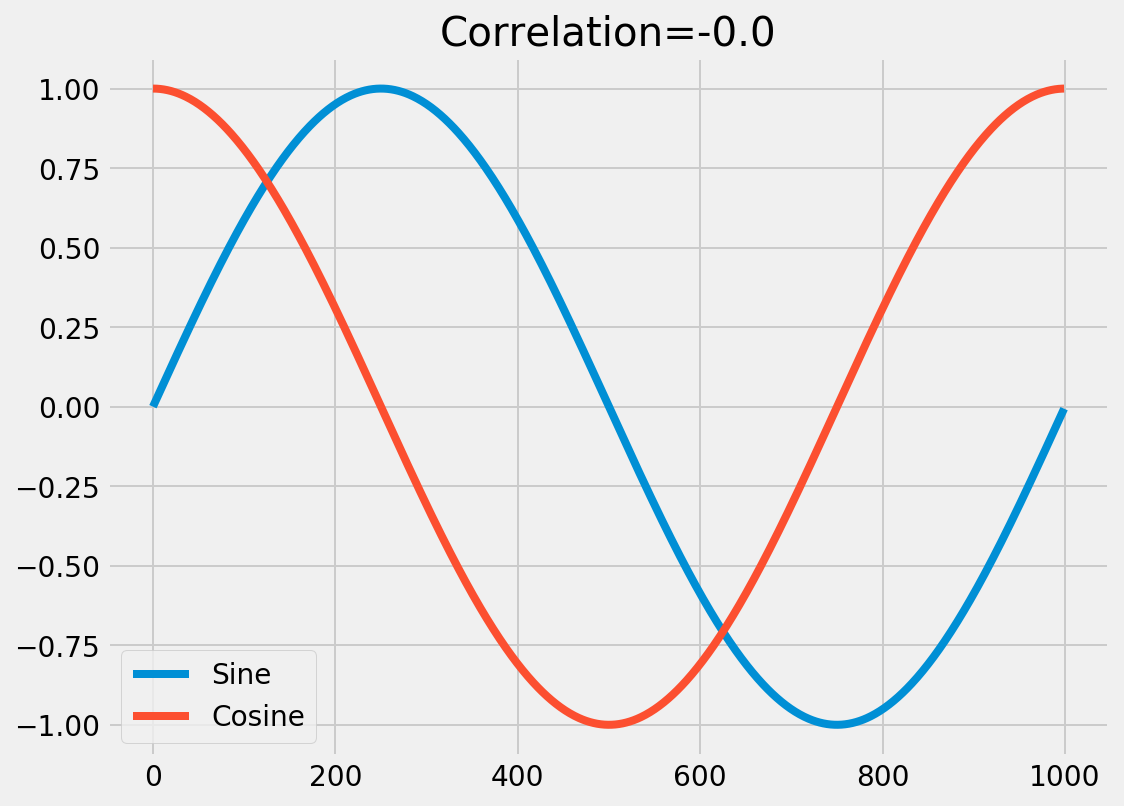

In [4]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')

# dissimilar signals have low correlation
signal1 = create_signal(10, 100, 'sin', 0.1)
signal2 = create_signal(10, 100, 'cos', 0.1)
plt.plot(signal1, label='Sine')
plt.plot(signal2, label='Cosine')
plt.title('Correlation={:.1f}'.format(np.dot(signal1, signal2)))
plt.legend()
plt.show()

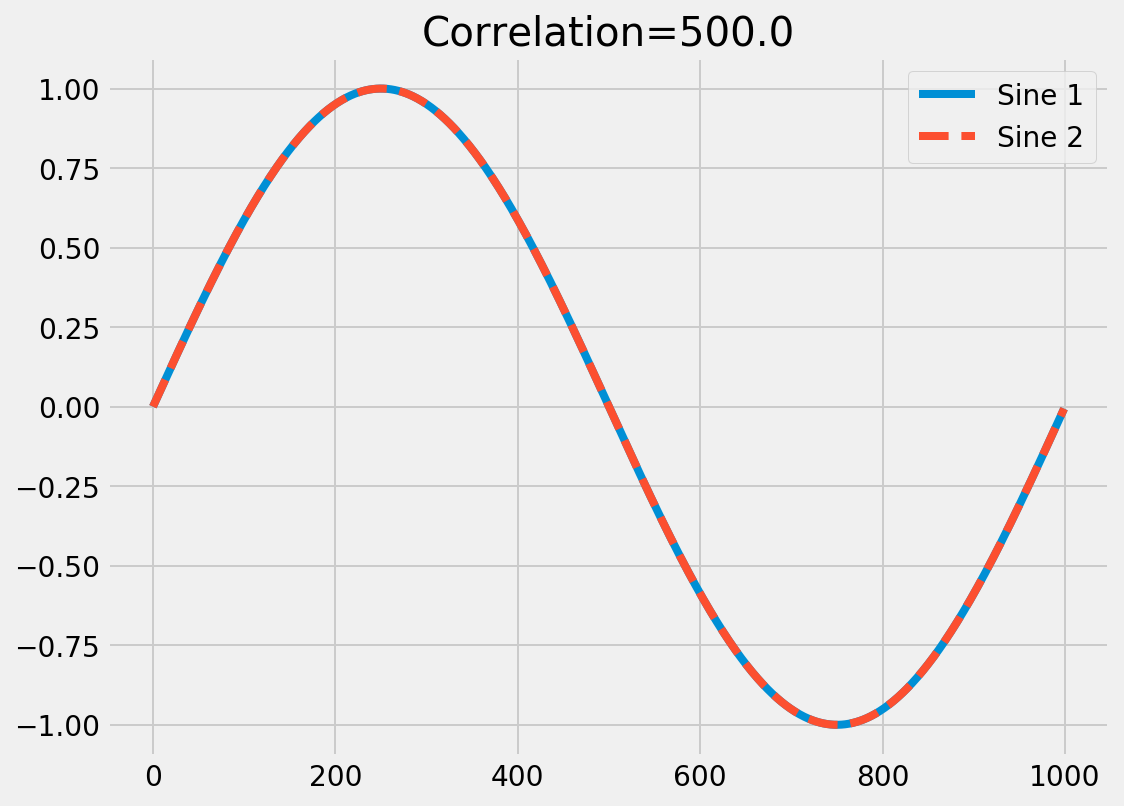

In [5]:
# similar signals have high correlation
signal1 = create_signal(10, 100, 'sin', 0.1)
signal2 = create_signal(10, 100, 'sin', 0.1)
plt.plot(signal1, label='Sine 1')
plt.plot(signal2, label='Sine 2', linestyle='--')
plt.title('Correlation={}'.format(np.dot(signal1, signal2)))
plt.legend()
plt.show()

Correlation is one of the key concept behind DFT, because as we'll soon see, in DFT, our goal is to find frequencies that gives a high correlation with the signal at hand and a high amplitude of this correlation indicates the presence of this frequency in our signal.

## Fourier Transformation

Fourier Transformation takes a time-based signal as an input, measures every possible cycle and returns the overall cycle components (by cycle, we're essentially preferring to circles). Each cycle components stores information such as for each cycle:

- **Amplitude:** how big is the circle?
- **Frequency:** How fast is it moving? The faster the cycle component is moving, the higher the frequency of the wave.
- **Phase:** Where does it start, or what angle does it start?

This cycle component is also referred to as **phasor**. The following gif aims to make this seemingly abstract description into a concrete process that we can visualize.

<img src="img/fft_decompose.gif">

After applying DFT to our signal shown on the right, we realized that it can be decomposed into five different phasors. Here, the center of the first phasor/cycle component is placed at the origin, and the center of each subsequent phasor is "attached" to the tip of the previous phasor. Once the chain of phasors is built, we begin rotating the phasor. We can then reconstruct the time domain signal by tracing the vertical distance from the origin to the tip of the last phasor.

Let's now take a look at DFT's formula:

\begin{align}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{ -\varphi \mathrm{i} }
\end{align}

- $x_n$: The signal's value at time $n$.
- $e^{-\varphi\mathrm{i}}$: Is a compact way of describing a pair of sine and cosine waves.
- $\varphi = \frac{n}{N} 2\pi k$: Records phase and frequency of our cycle components. Where $N$ is the number of samples we have. $n$ the current sample we're considering. $k$ the currenct frequency we're considering. The $2\pi k$ part represents the cycle component's speed measured in radians and $n / N$ measures the percentage of time that our cycle component has traveled.
- $X_k$ Amount of cycle component with frequency $k$.

> Side Note: If the readers are a bit rusty with trigonometry (related to sine and cosine) and complex numbers. e.g. There're already many excellent materials out there that covers these concepts. [Blog: Trigonometry Review](https://jackschaedler.github.io/circles-sines-signals/trig_review.html) and [Blog: Complex Numbers](https://jackschaedler.github.io/circles-sines-signals/complex.html)

From the formula, we notice that it's taking the dot product between the original signal $x_n$ and $e^{ -\varphi \mathrm{i} }$. If we expand $e^{ -\varphi \mathrm{i} }$ using the Euler's formula. $e^{ -\varphi \mathrm{i} } = cos(\varphi) - sin(\varphi)i$, we end up with the formula:

\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot \big( cos(\varphi) - sin(\varphi)i \big) \\
    &= \sum_{n=0}^{N-1} x_n \cdot cos(\varphi) - i \sum_{n=0}^{N-1} x_n \cdot sin(\varphi)
\end{align}

By breaking down the formula a little bit, we can see that underneath the hood, what fourier transformation is doing is taking the input signal and doing 2 correlation calculations, one with the sine wave (it will give us the y coordinates of the circle) and one with the cosine wave (which will give us the x coordinates or the circle). And the following succinct one-sentence colour-coded explanation is also a great reference that we can use for quick reference.

<img src="img/fft_one_sentence.png" width="50%" height="50%">

## DFT In Action

To see DFT in action, we will create a dummy signal that will be composed of four sinusoidal waves of different frequencies. 0, 10, 2 and 0.5 Hz respectively.

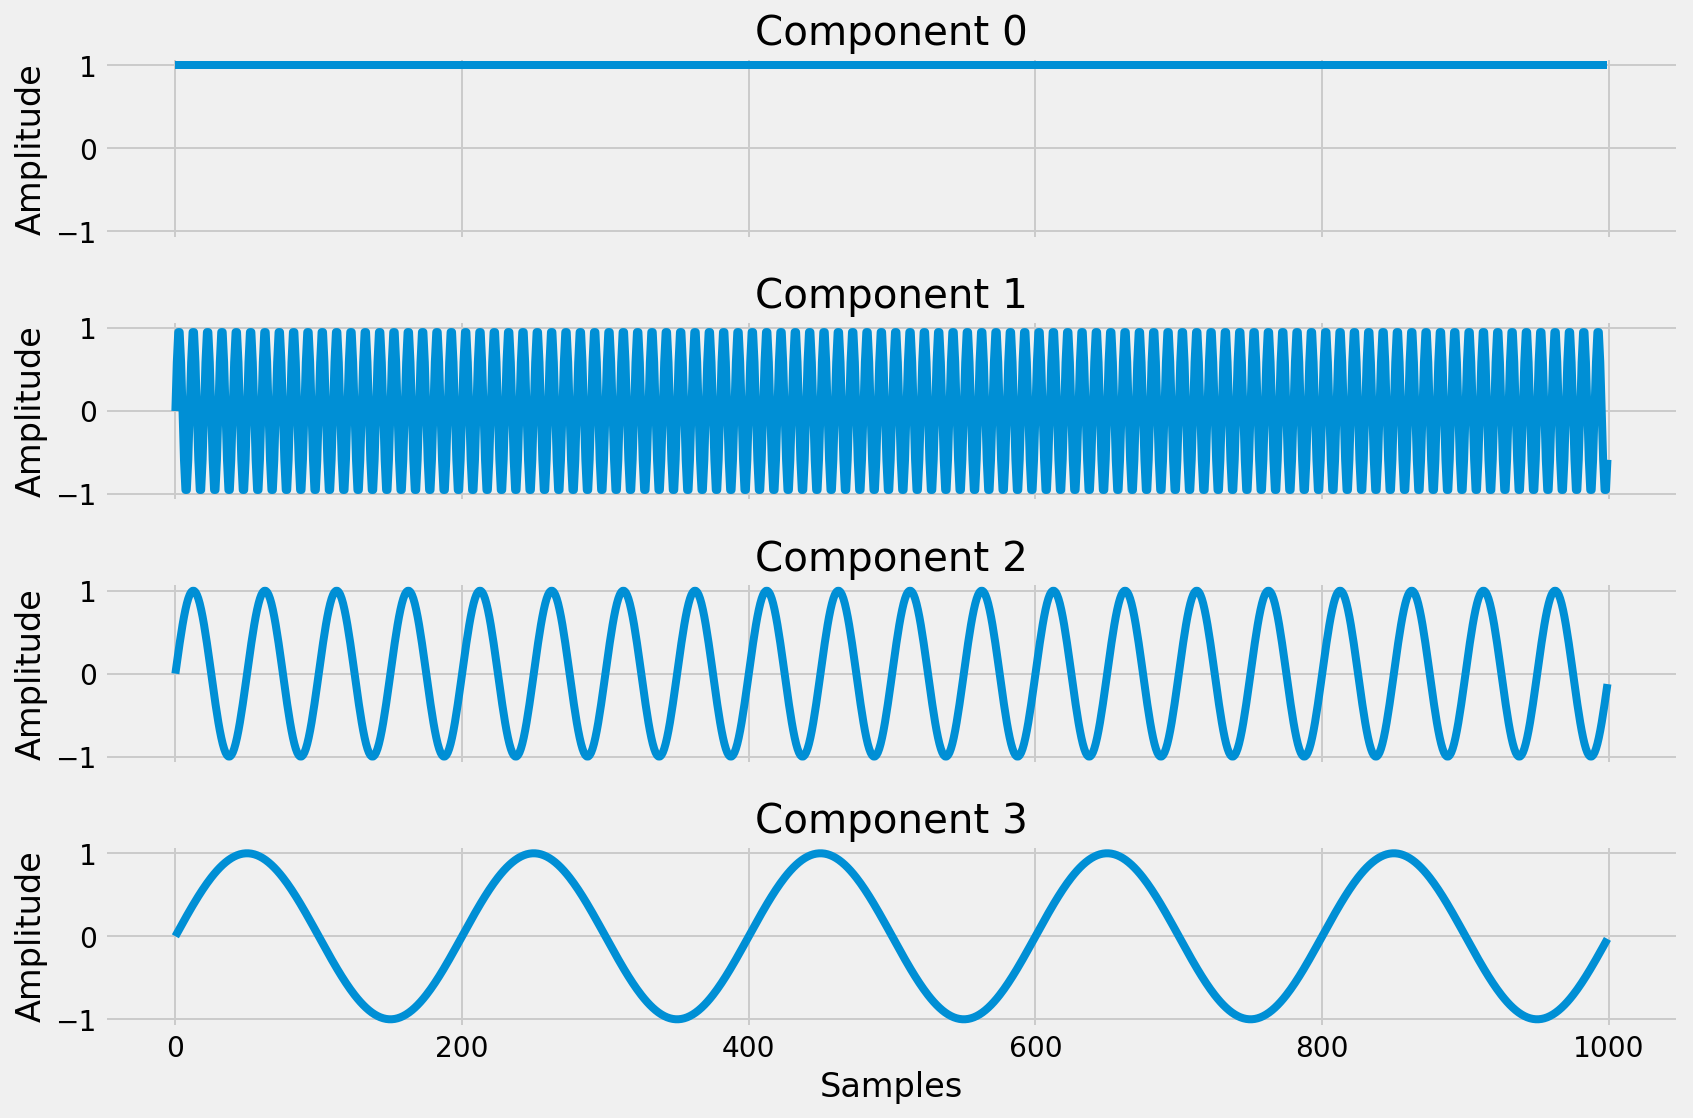

In [6]:
# reminder:
# sample_duration means we're collecting the data for x seconds
# sample_freq means we're sampling x times per second
sample_duration = 10
sample_freq = 100
signal_type = 'sin'
num_samples = sample_freq * sample_duration
num_components = 4

components = np.zeros((num_components, num_samples))
components[0] = np.ones(num_samples)
components[1] = create_signal(sample_duration, sample_freq, signal_type, 10)
components[2] = create_signal(sample_duration, sample_freq, signal_type, 2)
components[3] = create_signal(sample_duration, sample_freq, signal_type, 0.5)

fig, ax = plt.subplots(nrows=num_components, sharex=True, figsize=(12,8))
for i in range(num_components):
    ax[i].plot(components[i])
    ax[i].set_ylim((-1.1, 1.1))
    ax[i].set_title('Component {}'.format(i))
    ax[i].set_ylabel('Amplitude')

ax[num_components - 1].set_xlabel('Samples')
plt.tight_layout()

Then we will combine these individual signals together with some weights assigned to each signal.

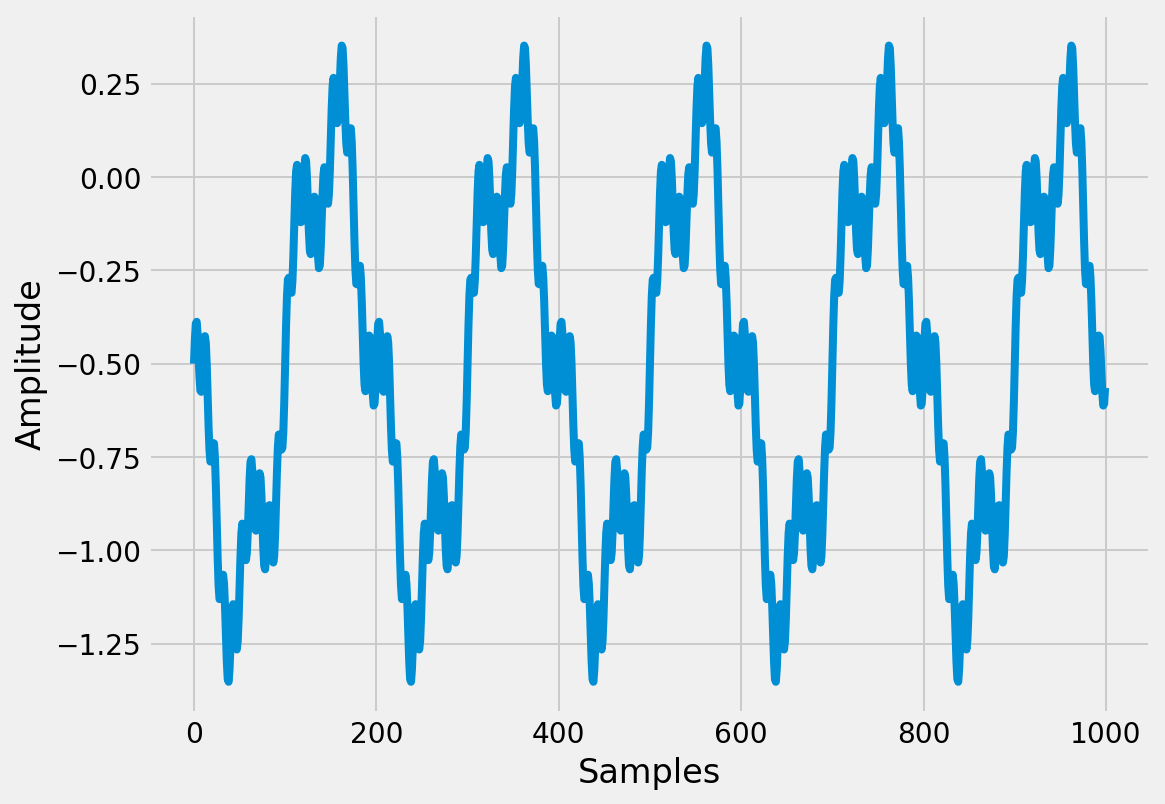

In [7]:
signal = -0.5 * components[0] + 0.1 * components[1] + 0.2 * components[2] - 0.6 * components[3]

plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

By looking at the dummy signal we've created visually, we might be able to notice the presence of a signal which shows 5 periods in the sampling duration of 10 seconds. In other words, after applying DFT to our signal, we should expect the presence a signal with the frequency of 0.5 HZ.

Here, we will leverage numpy's implementation to check whether the result makes intuitive sense or not. The implementation is called `fft`, but let's not worry about that for the moment.

In [8]:
fft_result = np.fft.fft(signal)
print('length of fft result: ', len(fft_result))
fft_result[:5]

length of fft result:  1000


array([-5.00000000e+02+0.00000000e+00j,  2.25951276e-13+8.46545056e-15j,
        1.28375093e-13+1.50003997e-13j,  5.19653030e-14+1.99840144e-15j,
       -4.90882687e-15+1.16994724e-13j])

The `fft` routine returns an array of length 1000 which is equivalent to the number of samples. If we look at each individual element in the array, we'll notice that these are the DFT coefficients. It has two components, the real number corresponds to the cosine waves and the imaginary number that comes from the sine waves. In general though, we don't really care if there's a cosine or sine wave present, as we are only concerned which frequency pattern has a higher correlation with our original signal. This can be done by considering the absolute value of these coefficients.

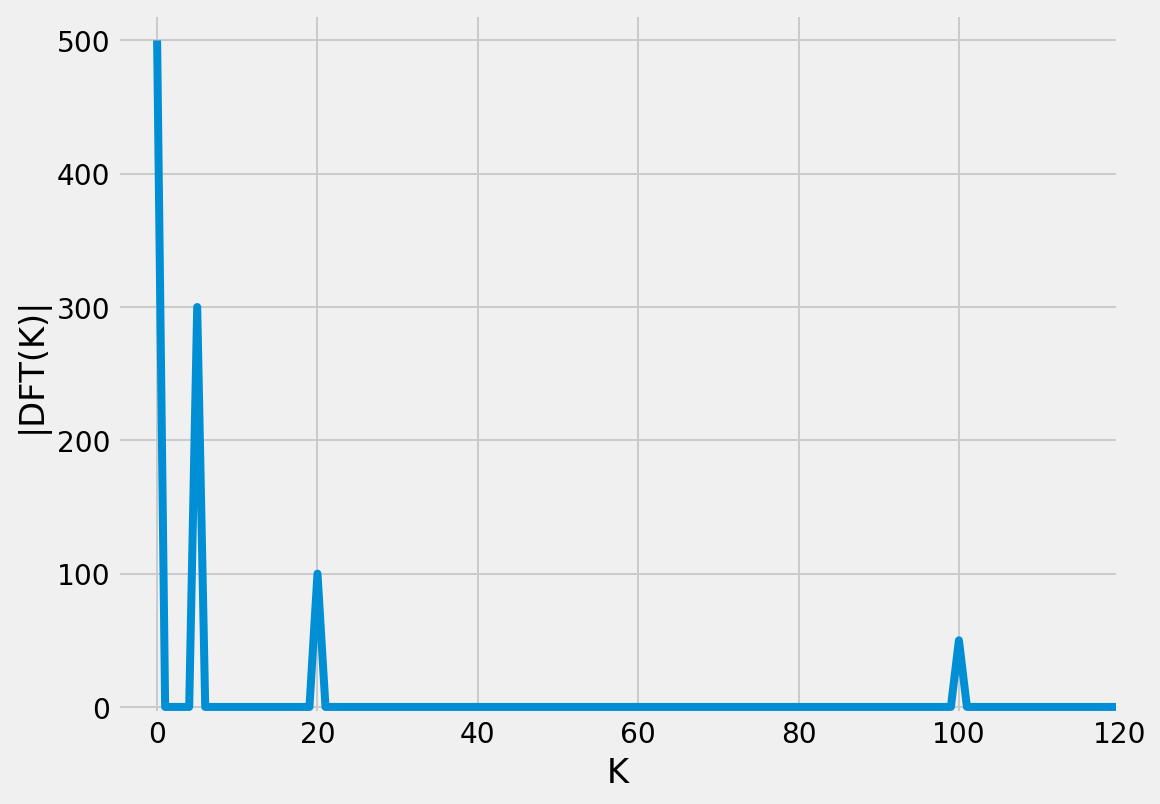

In [9]:
plt.plot(np.abs(fft_result))
plt.xlim((-5, 120))  # notice that we limited the x-axis to 120 to focus on the interesting part
plt.ylim((-5, 520))
plt.xlabel('K')
plt.ylabel('|DFT(K)|')
plt.show()

If we plot the absolute values of the `fft` result, we can clearly see a spike at K=0, 5, 20, 100 in the graph above. However, we are often times more interested in the energy of of each frequency. **Frequency Resolution** is the distance in Hz between two adjacent data points in DFT, which is defined as:

\begin{align}
\Delta f = \frac{f_s}{N}
\end{align}

Where $f_s$ is the sampling rate and $N$ is the number of data points. The denominator can be expressed in terms of sampling rate and time, $N = f_s \cdot t$. Looking closely at the formula, it is telling us the only thing that increases frequency resolution is time.

In our case, the `sample_duration` we've specified above was 10, thus the frequencies corresponding to these K are: 0 Hz, 0.5 Hz, 2 Hz and 10 Hz respectively (remember that these frequencies were the components that was used in the dummy signal that we've created). And based on the graph depicted below, we can see that by passing our signal to a DFT, we were able to retrieve its underlying frequency information.

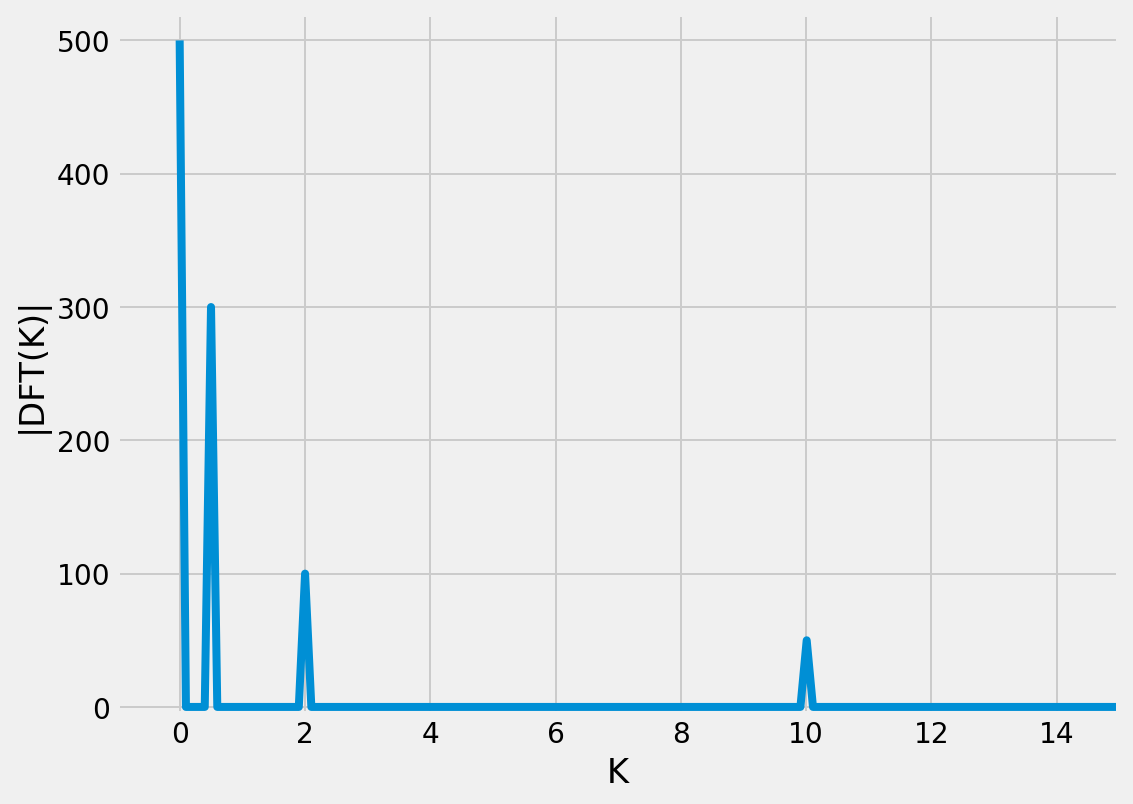

In [10]:
t = np.linspace(0, sample_freq, len(fft_result))
plt.plot(t, np.abs(fft_result))
plt.xlim((-1, 15))
plt.ylim((-5, 520))
plt.xlabel('K')
plt.ylabel('|DFT(K)|')
plt.show()

## Fast Fourier Transformation (FFT)

Recall that the formula for Discrete Fourier Transformation was:

\begin{align}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{ -\frac{n}{N} 2\pi k \mathrm{i} }
\end{align}

Since we now know that it's computing the dot product between the original signal and a cycle component at every frequency, we can implement this ourselves.

In [12]:
def dft(x):
    """Compute the Discrete Fourier Transform of the 1d ndarray x."""
    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    # complex number in python are denoted by the j symbol,
    # instead of i that we're showing in the formula
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, x)

result matches: True


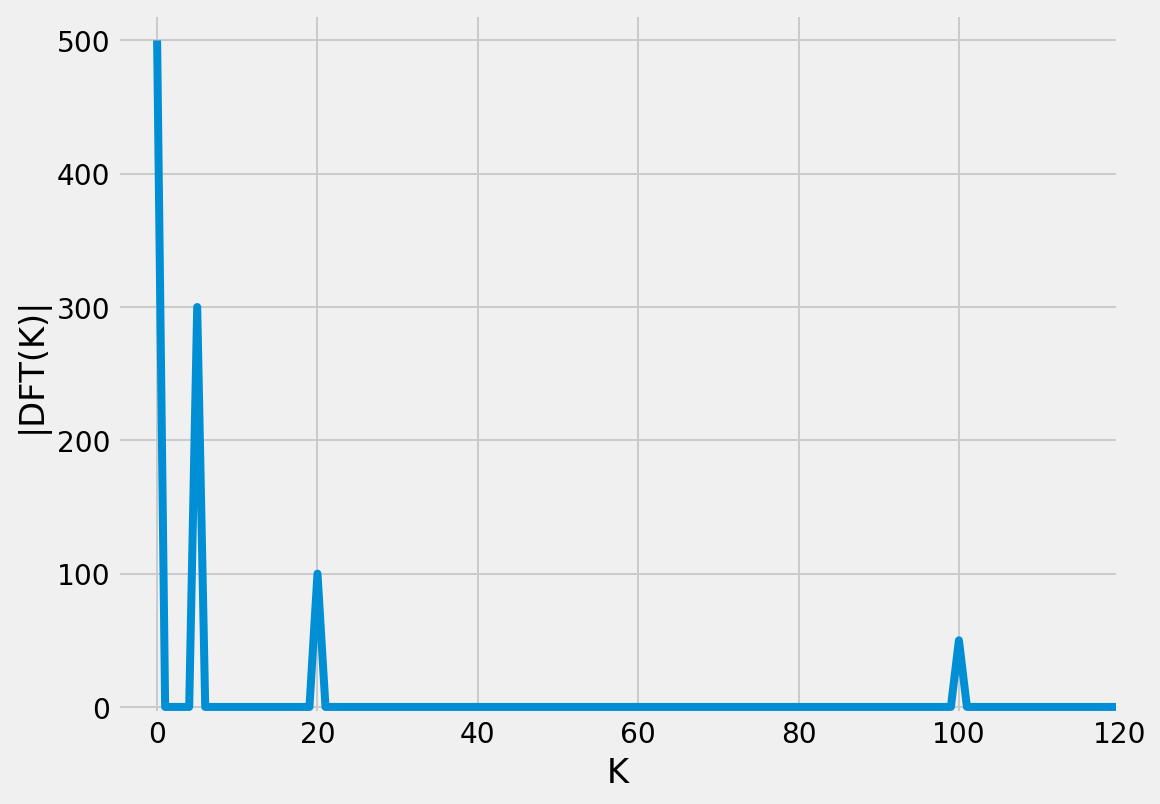

In [13]:
# apply dft to our original signal and confirm
# the results looks the same
dft_result = dft(signal)
print('result matches:', np.allclose(dft_result, fft_result))

plt.plot(np.abs(dft_result))
plt.xlim((-5, 120))
plt.ylim((-5, 520))
plt.xlabel('K')
plt.ylabel('|DFT(K)|')
plt.show()

However, if we compare the timing between our simplistic implementation versus the one from numpy, we can see a dramatic time difference.

In [14]:
%timeit dft(signal)
%timeit np.fft.fft(signal)

34.1 ms ± 898 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.8 µs ± 535 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


If we leave aside the fact that one is implemented using Python's numpy and one is most likely implemented in optimized C++, the time difference actually comes from the fact that in practice, people uses a more optimized version of Fourier Transformation called **Fast Fourier Transformation** (how unexpected ...) to perform the calculation. The algorithm accomplish significant speedup by exploiting symmetry property. i.e. if we devise a hypothetical algorithm which can decompose a 1024-point DFT into two 512-point DFTs, then we are essentially halving our computational cost. Let's take a look at how we can achieve this by looking at an example with 8 data points.

\begin{align}
X_k = x_0 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 0 } + x_1 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } + \dots + x_7 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 7 }
\end{align}


Our goal is to examine the possibility of rewriting this eight-point DFT in terms of two DFTs of smaller length. Let's first examine choosing all the terms with an even sample index, i.e. $x_0$, $x_2$, $x_4$, and $x_6$. Giving us:

\begin{align}
G_k &= x_0 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 0 } + x_2 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 2 } + x_4 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 4 } + x_6 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 6 } \\
    &= x_0 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 0 } + x_2 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 1 } + x_4 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 2 } + x_6 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 3 }
\end{align}

After plugging the values for the even sample index and simplifying the fractions in the complex exponentials, we can observe that our $G_k$ is a 4 samples DFT with $x_0$, $x_2$, $x_4$, $x_6$ as our input signal. Now that we've shown that we can decompose the even index samples, let's see if we can simplify the remaining terms, the odd-index samples, are given by:

\begin{align}
Q_k &= x_1 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } + x_3 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 3 } + x_5 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 5 } + x_7 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 7 } \\
    &= e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } \cdot \big( x_1 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 0 } + x_3 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 2 } + x_5 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 4 } + x_7 \cdot e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 6 } \big) \\
    &= e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } \cdot \big( x_1 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 0 } + x_3 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 1 } + x_5 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 2 } + x_7 \cdot e^{ -\mathrm{i} \frac{2\pi}{4} k ~\times~ 3 } \big) \\
    &= e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } \cdot H_k
\end{align}

After the derivation, we can see our $Q_k$ is obtained by multiplying $e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 }$ by the four point DFT with the odd index samples of $x_1$, $x_3$, $x_5$, $x_7$, which we'll denote as $H_k$. Hence, we have achieved the goal of decomposing an eight-point DFT into two four-point ones:

\begin{align}
X_k &= G_k + e^{ -\mathrm{i} \frac{2\pi}{8} k ~\times~ 1 } \cdot H_k
\end{align}

We have only worked through rearranging the terms a bit, next we'll introduce a symmetric trick that allows us to compute the sub-result only once and save computational cost.

The question that we'll be asking ourselves is what is the value of $X_{N+k}$ is. From our above expression:


\begin{align}
X_{N + k} &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
\end{align}

Here we've used the property that $exp[2\pi~i~n] = 1$ for any integer $n$, since $exp[2\pi~i]$ means that we're going 1 full circle, and multiplying that number by any integer $n$ means we're spinning for $n$ circles. The last line shows a nice symmetry property of the DFT: $X_{N+k}=X_k$. This means when we break our eight-point DFT into two four-point DFTs, it allows us to re-use a lot of the results for both $X_k$ and $X_{k + 4}$ and significantly reduce the number of calculations through the symmetric property:

\begin{align}
X_{k + 4} &= G_{k + 4} + e^{ -\mathrm{i} \frac{2\pi}{8} (k + 4) ~\times~ 1 } \cdot H_{k + 4} \\
          &= G_k + e^{ -\mathrm{i} \frac{2\pi}{8} (k + 4) ~\times~ 1 } \cdot H_k
\end{align}

We saw that the starting point of the algorithm was that the DFT length $N$ was even and we were able to decrease the computation by splitting it into two DFTS of length $N/2$, following this procedure we can again decompose each of the $N/2$ DFTs into two $N/4$ DFTs. This property turns the original $\mathcal{O}[N^2]$ DFT computation into a $\mathcal{O}[N\log N]$ algorithm to compute DFT.

In [15]:
def fft(x):
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError('size of x must be a power of 2')
    elif N <= 32:  # this cutoff should be enough to start using the non-recursive version
        return dft(x)
    else:
        fft_even = fft(x[0::2])
        fft_odd = fft(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([fft_even + factor[:N // 2] * fft_odd,
                               fft_even + factor[N // 2:] * fft_odd])

In [16]:
# here, we assume the input data length is a power of two
# if it doesn't, we can choose to zero-pad the input signal
x = np.random.random(1024)
np.allclose(fft(x), np.fft.fft(x))

True

In [17]:
%timeit dft(x)
%timeit fft(x)
%timeit np.fft.fft(x)

36.7 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.62 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
27.6 µs ± 711 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


By re-vising our algorithm that we use to compute DFT, we have improved our implementation by an order of magnitude! The algorithm we've implemented here is also referred to as the [radix-2 Cooley-Tukey FFT](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm).

Though the pure-Python functions are probably not useful in practice, as due to the importance of the FFT in so many applications, Both NumPy, `numpy.fft`, and SciPy, `scipy.fftpack` have wrappers of the extremely well-tested FFTPACK library. But I still believe that by spending the time to get an intuition of what's happening underneath the hood of these tools, the better practitioners we'll be.

Application of DFT in the context of equipment condition monitoring. [Blog: Fast Fourier Transforms in Python](https://ericstrong.org/fast-fourier-transforms-in-python/)

# Reference

- [Blog: Understanding the FFT Algorithm](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)
- [Blog: Dummies guide to Fourier Transform](https://nipunbatra.github.io/blog/2016/FT.html)
- [Blog: An Introduction to the Fast Fourier Transform](https://www.allaboutcircuits.com/technical-articles/an-introduction-to-the-fast-fourier-transform/)
- [Blog: An Intuitive Discrete Fourier Transform Tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/intuitive-guide-discrete-fourier-transform/)
- [Blog: Understanding the Fourier Transform by example](https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/)
- [Blog: The Fourier Transform, explained in one sentence](https://blog.revolutionanalytics.com/2014/01/the-fourier-transform-explained-in-one-sentence.html)
- [Blog: Seeing Circles, Sines, And Signals a Compact Primer On Digital Signal Processing](https://jackschaedler.github.io/circles-sines-signals/index.html)